In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results__.html
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__notebook__.ipynb
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__output__.json
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/custom.css
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results___files/__results___28_3.png
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results___files/__results___28_4.png
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results___files/__results___28_1.png
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results___files/__results___28_5.png
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results___files/__results___34_1.png
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results___files/__results___28_6.png
/kaggle/input/mvtec-ad-anomaly-detection-with-anomalib-library/__results_

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
import os
from torchvision.io import read_image
from PIL import Image


In [3]:
class textile(Dataset):
    def __init__(self,root_dir,train=True,transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.image_paths = []

        if self.train:
            normal_dir = os.path.join(root_dir,"train","good")
            for filename in os.listdir(normal_dir):
                if filename.endswith('.png'):
                    self.image_paths.append(os.path.join(normal_dir,filename))
        else:
            for subfolder in os.listdir('/kaggle/input/mvtec-ad/carpet/test'): #This will include all subfolders
                test_dir = os.path.join(root_dir,'test',subfolder)
                for filename in os.listdir(test_dir):
                    if filename.endswith('.png'):
                        self.image_paths.append(os.path.join(test_dir,filename))
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return image

In [17]:
image_size = 256
transform_func = transforms.Compose([
    # transforms.ToPILImage(), #convert to PIL image to handle transforms
    transforms.Resize(image_size),
    transforms.ToTensor(), #convert back to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [18]:
os.chdir('/kaggle/input/mvtec-ad')

In [19]:
train_dataset = textile(root_dir='carpet',transform=transform_func,train=True)
test_dataset = textile(root_dir='carpet',transform=transform_func,train=False)

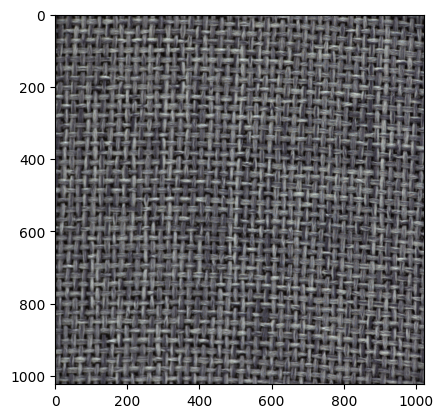

In [20]:
plt.imshow(cv2.imread('/kaggle/input/mvtec-ad/carpet/train/good/000.png'))

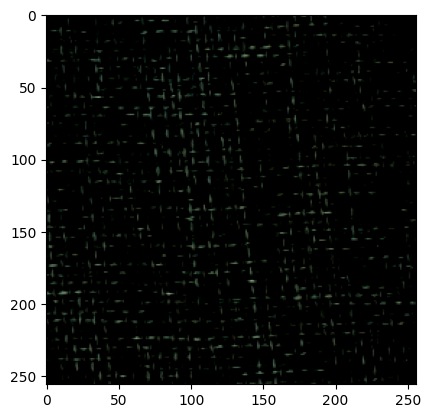

In [21]:
plt.imshow(train_dataset[0].permute(1,2,0).cpu().numpy())

In [22]:
train_loader = DataLoader(train_dataset,batch_size=8,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=8,shuffle=False)

In [23]:
class SimpleEncoder(nn.Module):
    def __init__(self):
        super(SimpleEncoder,self).__init__()
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,1,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU(),
            nn.Conv2d(64,128,3,1,1),
            nn.ReLU(),
            nn.Conv2d(128,256,3,1,1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,3,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,3,3,1,1),
            nn.Sigmoid(),
        ) 

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
model = SimpleEncoder().to(device)

In [26]:
#hyper param
optimizer = optim.Adam(model.parameters(),lr = 1e-03)
loss_fn = nn.MSELoss()
# from pytorch_msssim import SSIM
# loss_fn = SSIM()
epochs = 25

In [ ]:
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        # print(pred.shape)
        # print(batch.shape)
        loss = loss_fn(pred,batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} | Loss: {avg_loss}')

Epoch: 0 | Loss: 0.1687823427574975
Epoch: 1 | Loss: 0.13410370775631497
Epoch: 2 | Loss: 0.13410370647907258
Epoch: 3 | Loss: 0.13410370647907258
Epoch: 4 | Loss: 0.13410370775631497
Epoch: 5 | Loss: 0.13410370775631497
Epoch: 6 | Loss: 0.13410370775631497
Epoch: 7 | Loss: 0.13410370903355734
Epoch: 8 | Loss: 0.13410370775631497
Epoch: 9 | Loss: 0.13410370775631497
Epoch: 10 | Loss: 0.13410370690482004
Epoch: 11 | Loss: 0.13410370775631497
Epoch: 12 | Loss: 0.1341037081820624
Epoch: 13 | Loss: 0.13410370775631497


Original test image shape: torch.Size([1, 3, 128, 128])
Reconstructed image shape: torch.Size([1, 3, 128, 128])


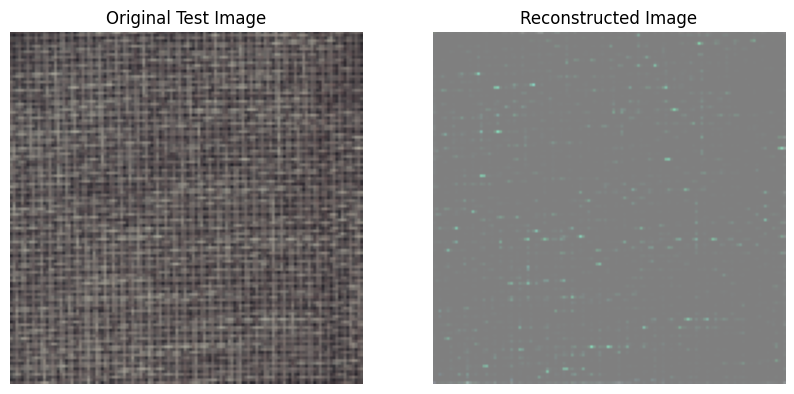

Reconstruction Error: 0.10025263577699661
The image is likely defective.


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from torchvision import transforms

# Path to a test image (defect category)
test_image_path = "/kaggle/input/mvtec-ad/carpet/test/good/006.png"  # Replace with actual path

# Load and preprocess the test image
def preprocess_image(image_path, image_size=(128, 128)):  # Ensure the size matches the model input
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] range
    ])
    image = Image.open(image_path).convert("RGB")  # Open and ensure it's in RGB format
    return transform(image).unsqueeze(0)  # Add batch dimension

# Load the test image
test_image = preprocess_image(test_image_path)

# Pass the test image through the autoencoder
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    reconstructed_image = model(test_image.to(device))

# Check the shapes of the tensors before squeezing
print(f"Original test image shape: {test_image.shape}")
print(f"Reconstructed image shape: {reconstructed_image.shape}")

# Ensure we only squeeze the batch dimension if it exists (i.e., batch size = 1)
if test_image.dim() == 4:  # Check if there is a batch dimension
    test_image_np = test_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
else:
    test_image_np = test_image.permute(1, 2, 0).cpu().numpy()

if reconstructed_image.dim() == 4:  # Check if there is a batch dimension
    reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
else:
    reconstructed_image_np = reconstructed_image.permute(1, 2, 0).cpu().numpy()

# De-normalize (if normalization was applied during preprocessing)
test_image_np = (test_image_np * 0.5) + 0.5  # Reverse normalization to [0, 1]
reconstructed_image_np = (reconstructed_image_np * 0.5) + 0.5

# Visualize the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image_np)
plt.title("Original Test Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()

# Compute the reconstruction error (Mean Squared Error)
def compute_reconstruction_error(original, reconstructed):
    # Compute the MSE (Mean Squared Error) between the original and reconstructed image
    return torch.mean((original - reconstructed) ** 2)

# Convert images to tensors for error calculation (remove batch dimension)
if test_image.dim() == 4:
    test_image_tensor = test_image.squeeze(0)
else:
    test_image_tensor = test_image

if reconstructed_image.dim() == 4:
    reconstructed_image_tensor = reconstructed_image.squeeze(0)
else:
    reconstructed_image_tensor = reconstructed_image

# Compute the MSE
reconstruction_error = compute_reconstruction_error(test_image_tensor.cpu(), reconstructed_image_tensor.cpu())
print(f"Reconstruction Error: {reconstruction_error.item()}")

# Set a threshold for classification
threshold = 0.01  # This value can be adjusted based on your dataset

# Classify as defective or not based on the reconstruction error
if reconstruction_error.item() > threshold:
    print("The image is likely defective.")
else:
    print("The image is likely normal.")
